In [ ]:
%pip install numpy pandas Pillow

In [ ]:
from sys import platform
import subprocess

# if the platform is Mac OS X, install the nightly build of PyTorch
if platform == "darwin":
  print("Installing nightly build of PyTorch for Mac OS X")
  # %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
  subprocess.run(["pip", "install", "--pre", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/nightly/cpu"])
elif platform == "win32":
  print("Installing PyTorch for Windows")
  # %pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/cu117"])
# if the platform is Linux, install the nightly build of PyTorch
else:
  print("Installing PyTorch for Linux")
  # %pip install torch torchvision torchaudio
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio"])

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
import numpy as np
from IPython.display import Image
from matplotlib import image, pyplot
import random
%matplotlib inline

In [ ]:
# Use GPU if it exists - for faster execution
# Device selection for PyTorch
device = torch.device("cpu")

# Device selection for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

device

In [ ]:
# Download the dataset and unzip - RUN ONLY ONCE!
zip_file_url = "https://austons-ml-bucket.s3.fr-par.scw.cloud/cats_and_dogs_filtered.zip"
import requests, zipfile, sys



def downloadFile(url: str):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter
    print("Downloading %s!" % local_filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_length = r.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(r.content)
        else:
            dl = 0
            total_length  = int(total_length)
            with open(f"./data/{local_filename}", 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):
                    dl += len(chunk)
                    f.write(chunk)
                    done = int(50 * dl / total_length)
                    # must be only two decimal places
                    done_percentage = round(dl / total_length * 100, 2)
                    sys.stdout.write("\r[%s%s] %s" % ('=' * done, ' ' * (50-done), done_percentage))
                    sys.stdout.flush()
    print("\nDownload complete!")
    return local_filename

# Check if the data folder exists, if not, create it
import os
if not os.path.exists("./data/"):
    os.makedirs("./data/")

local_filename = zip_file_url.split('/')[-1]
# check if the zip file exists, if not, download it
if not os.path.exists("./data/" + local_filename):
    downloadFile(zip_file_url)
    # unzip the file
    print("Unzipping the file")
    with zipfile.ZipFile("./data/" + local_filename, 'r') as zip_ref:
        zip_ref.extractall("./data/")
    print("Done!")
else:
    print("The zipped data file already exists")

In [13]:
# Import all the images into the memory
# Lets check how many files are in the dataset
import os
from typing import List
from matplotlib import image


def getAllFiles(categories: List[str], data_root: str, includeFileData=False) -> dict:
  filesByCategory = {}

  for category in categories:
    count = 0
    full_path = data_root + category + "s"

    for file_name in os.listdir(full_path): 
      count+=1
      file_path = full_path + "/" + file_name
      file = {
        "file_name": file_name,
        "file_path": file_path,
        "data": None
      }
      
      if includeFileData:
        file["data"] = image.imread(file_path)
        
      if category in filesByCategory.keys():
        filesByCategory[category].append(file)
      else:
        filesByCategory[category] = [file]

    print(f"Total {category} images: {count}")
  return filesByCategory

# Label Encoder!

In [10]:
classes = ["cat", "dog"]

class LabelTransformer():
    labels_map = {}
    labels_id_map = {}
    
    def __init__(self, labels):
        # Create a labelMap
        labels_set = set(labels)

        for id,val in enumerate(labels_set):
            self.labels_map[val] = id
            self.labels_id_map[id] = val

    def encoder(self, label):
        return self.labels_map[label]

    def decoder(self, label_encoded):
        return self.labels_id_map[label_encoded]

label_transformer = LabelTransformer(classes)  

In [14]:
train_dataset_path = "./data/cats_and_dogs_filtered/train/"
validation_dataset_path = "./data/cats_and_dogs_filtered/validation/"
filesByCategory = getAllFiles(classes, train_dataset_path)

Total cat images: 1000
Total dog images: 1000


In [ ]:
for category in filesByCategory:
  print(f"------{category}!----")
  file_path = filesByCategory[category][0]["file_path"]
  my_image = image.imread(file_path)
  print(my_image.dtype)
  print(my_image.shape)
  pyplot.imshow(my_image)
  pyplot.show()
  

In [ ]:
# Create X Train and y Train
trainingfilesByCategory = getAllFiles(classes, train_dataset_path, False)
X_train = []
y_train = []

for i in range(0, len(classes)):
  category = classes[i]
  for file in trainingfilesByCategory[category]:
    X_train.append(file["file_path"])
    y_train.append(category)
    
# Create X Validation and y Validation
validationfilesByCategory = getAllFiles(classes, validation_dataset_path, False)
X_validation = []
y_validation = []

for i in range(0, len(classes)):
  category = classes[i]
  for file in trainingfilesByCategory[category]:
    X_validation.append(file["file_path"])
    y_validation.append(category)


In [ ]:
# Create the dataset for DataLoader
from torchvision.io import read_image

torch.manual_seed(17)

class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_paths, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [ ]:
# Create the DataLoader with some transformations
image_size = 224
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    T.RandomResizedCrop(image_size),
    T.RandomHorizontalFlip(),
    T.Grayscale(),
    T.ToTensor()])

In [ ]:
batch_size = 64

train_dataset = CustomImageDataset(img_labels=y_train, img_paths=X_train, transform=transform, target_transform=label_transformer.encoder)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)

validation_dataset = CustomImageDataset(img_labels=y_validation, img_paths=X_validation, transform=transform, target_transform=label_transformer.encoder)
validation_dl = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
tensor = train_dl.dataset[0][0]
pilTransform = T.ToPILImage()
transformedImage = pilTransform(tensor)
display(transformedImage)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = pyplot.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for batch in dl:
        images, labels = batch
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
train_dataset[0][0].shape

# CNN Model!

In [2]:
# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# Craete a neural network from pytorch
# class Cnn(nn.Module):
#     def __init__(self):
#         super(Cnn,self).__init__()
        
#         self.layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=2)
#         self.bactchnorm = nn.BatchNorm2d(num_features=16)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2)

#         self.fc1 = nn.Linear(55 * 55 * 16, 2)
#         self.relu = nn.ReLU()
        
        
#     def forward(self,x):
#         # Layer 1
#         out = self.layer1(x)
#         out = self.bactchnorm(out)
#         out = self.relu(out)
#         out = self.maxpool(out)
#         # Layer 1 -----

#         out = self.relu(out)
#         out = out.view(out.size(0), out.size(1)*out.size(2)* out.size(3))
#         out = self.fc1(out)
#         return out

# ------------
model = Cnn().to(device)
model.train()

# -------
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()


model

In [ ]:
import time


def validateModel(model, dataloader, criterion, epoch):
    with torch.no_grad():
        t0 = time.time()
        
        epoch_val_accuracy=0
        epoch_val_loss=0

        for data, label in dataloader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            # Since optimizer isnt run here, we are not trainin the model, we will just check
            # the accuracy!
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(dataloader)
            epoch_val_loss += val_loss/ len(dataloader)
            
        t1 = time.time()
        print('Epoch : {}, val_accuracy : {}, val_loss : {}, time taken : {}'.format(epoch+1, epoch_val_accuracy, epoch_val_loss, t1 - t0))
        return epoch_val_accuracy, epoch_val_loss

def trainModel(model, dataloader, optimizer, criterion, epoch):
    
    t0 = time.time()
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_dl:
        data = data.to(device)
        label = label.to(device)
        
        # Get the output and loss
        output = model(data)
        loss = criterion(output, label)
        
        # Optimize the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Check for Accuracy
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(dataloader)
        epoch_loss += loss/len(dataloader)
    
    t1 = time.time()
    
    print('Epoch : {}, train accuracy : {}, train loss : {}, time taken : {}'.format(epoch+1, epoch_accuracy, epoch_loss, t1 - t0))
    return epoch_accuracy, epoch_loss 

        
# ----- EPOCH Training----
epochs = 200
train_acc_loss = []
val_acc_loss = []

for epoch in range(epochs):
    
    acc, loss = trainModel(model=model, dataloader=train_dl, criterion=criterion, optimizer=optimizer, epoch=epoch)
    train_acc_loss.append((acc.item(), loss.item()))

    acc, loss = validateModel(model=model, dataloader=validation_dl, criterion=criterion, epoch=epoch)
    val_acc_loss.append((acc.item(), loss.item()))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a plot for accuracy against each epoch
fig, (ax1, ax2) = plt.subplots(nrows=1,
                                        ncols=2,
                                        figsize=(20, 10))
# Training -----
# Train Accuracy per epoch
y = [acc for acc, loss in train_acc_loss]
x = np.arange(len(y))
ax1.plot(x, y, color='g', label='training Accuracy')


# Train Loss per epoch
y = [loss for acc, loss in train_acc_loss]
ax1.plot(x, y, color='b', label='trainig loss')


# Validation -----
# Validation Accuracy per epoch
y = [acc for acc, loss in val_acc_loss]
ax2.plot(x, y, color='r', label='validation Accuracy')

# Validation loss per epoch
y = [loss for acc, loss in val_acc_loss]
ax2.plot(x, y, color='y', label='validation loss')

ax1.set(title="Training", 
      ylabel="Accuracy/Loss", xlabel="Epoch");

ax2.set(title="Validation", 
      ylabel="Accuracy/Loss", xlabel="Epoch");

# Adding legend, which helps us recognize the curve according to it's color
ax1.legend();
ax2.legend(); 

# Saving the Model State

In [ ]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# Save the model state
torch.save(model.state_dict(), './model-state.pth')

## Inferencing!

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F

## *Run the CNN Model class from above blocks*

In [4]:
# Load the model
new_model = Cnn()
new_model.load_state_dict(torch.load(
        "./model-state.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

## *Run the LabelEncoder class from above blocks*

Transformed Image


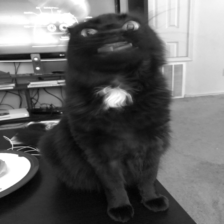

Tensor -> PIL Image


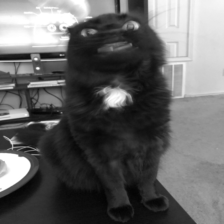

torch.Size([1, 224, 224])
torch.Size([1, 1, 224, 224])
output_class: dog
**************************************************
Its a  dog with a probability of  0.70141345
**************************************************
Class:  dog Prob:  0.70141345
Class:  cat Prob:  0.29858658


{'dog': 0.70141345, 'cat': 0.29858658}

In [29]:
# url="https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
# url="https://images.pexels.com/photos/2023384/pexels-photo-2023384.jpeg"
# url="https://cdn.pixabay.com/photo/2017/06/20/22/14/man-2425121_960_720.jpg"
# url = "https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png"
url = "https://i.redd.it/02rmlxw3lpa11.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
img = Image.open(BytesIO(response.content))
# display(img)

image_size = 224
# Transform this image
transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.Grayscale(),
    # T.ToTensor(),
])

# inference this image
print("Transformed Image")
transformed_img = transform(img)
display(transformed_img)

transformed_img_tensor = T.ToTensor()(transformed_img)

print("Tensor -> PIL Image")
img_n = T.ToPILImage()(transformed_img_tensor)
display(img_n)
# Inference this
new_model.eval()

print(transformed_img_tensor.size())
transformed_img_tensor_unsqueezed = transformed_img_tensor.unsqueeze(0)
print(transformed_img_tensor_unsqueezed.size())


output = new_model(transformed_img_tensor_unsqueezed)

# Apply softmax to the output
pred = F.softmax(output, dim=1)

# Get the class with the highest probability
output_class_id = pred.argmax(dim=1).detach().numpy()[0]

output_class = label_transformer.decoder(output_class_id)
print("output_class:", output_class)

print("*"*50)
print("Its a ", output_class, "with a probability of ", pred.detach().numpy()[0][output_class_id])
print("*"*50)

# Map the output class id to the name of the class
probs = {}
for i in range(len(pred.detach().numpy()[0])):
    print("Class: ", label_transformer.decoder(i), "Prob: ", pred.detach().numpy()[0][i])
    probs[label_transformer.decoder(i)] = pred.detach().numpy()[0][i]
probs

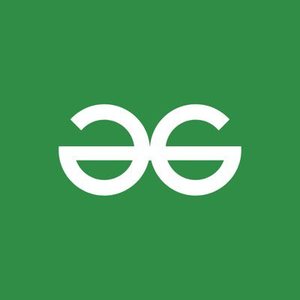

In [6]:
import urllib.request

from PIL import Image

urllib.request.urlretrieve(
  'https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png',
   "gfg.png")
  
img = Image.open("gfg.png")
display(img)

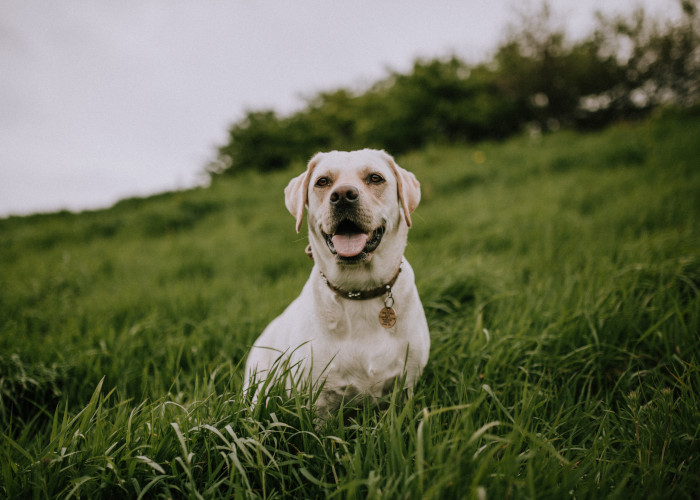

In [32]:
from PIL import Image
import requests
from io import BytesIO

# url = "https://media.geeksforgeeks.org/wp-content/uploads/20210318103632/gfg-300x300.png"
url = "https://www.inferdo.com/img/label-1.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

In [39]:
def get_thirdparty_image_labels(url):
    payload = {"url": url}
    headers = {
      "content-type": "application/json",
      "X-RapidAPI-Key": "c888010467msha782d4c79ee3a6fp110abbjsndc0927e072a6",
      "X-RapidAPI-Host": "image-labeling1.p.rapidapi.com"
    }
    response = requests.request("POST", "https://image-labeling1.p.rapidapi.com/img/label", headers=headers, json=payload)

    return response.json()


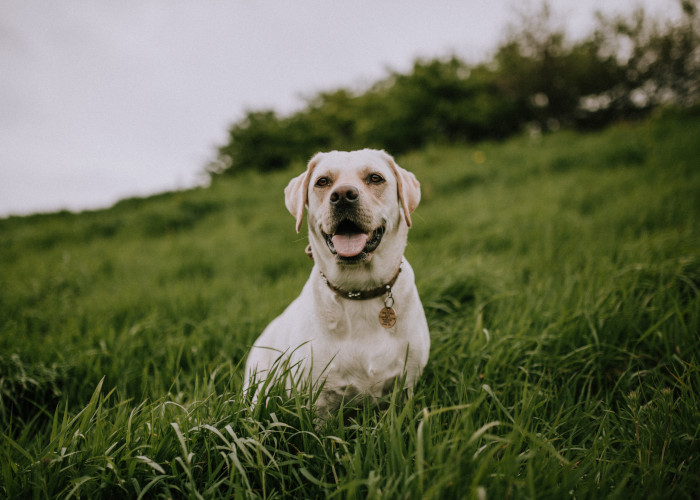

{'Pet': 0.9887031873654483,
 'Grass': 0.982273607395529,
 'Dog': 0.9808257471700607,
 'Animal': 0.9578073153142023,
 'Mammal': 0.9574545302451775,
 'Green': 0.8972517591151322,
 'Lawn': 0.8245252721572913,
 'Meadow': 0.7151362063799676,
 'Dog breed': 0.4819199130280332,
 'Puppy': 0.4473387531030606}

In [43]:
import requests


# url = "https://i.redd.it/02rmlxw3lpa11.jpg"
# url = "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
api_url = "https://image-labeling1.p.rapidapi.com/img/label"
url = "https://www.inferdo.com/img/label-1.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

get_thirdparty_image_labels(url)